# Working with GPS points

---
# Introduction

In this project, we are interested in a section of roadway that goes North/South and has two intersections. The roadway is a divided highway. Each side of the divided roadway has an intersection. The area of interest is shown in the figure above by the red box enclosed by the following **WGS-84** coordinates:
- Point 1: (34.241, 108.943)
- Point 2: (34.241, 108.9415)
- Point 3: (34.234, 108.9415)
- Point 4: (34.234, 108.943)

<img  src= "Figure1.JPG" width = 650> 

We provide one-day (10/03/2016) of GPS data from the city of Xi’an from DiDi Inc. Unfortunately, the dataset used an uncommon GCJ-2 coordinate system and was difficult to deal with. Therefore, we want to transform the coordinates from GCJ-2 to WGS-84.

The final goal of this project is to calculate the northbound and southbound average speeds at every 5-minute interval for the interested arterial road. 

---
# Import the Environment

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pyproj
%matplotlib inline

import evil_transform
from utils import load_sample, check_transform, check_vanilla_better_et, plot_gps
import time

---
# Load the Data

In [2]:
sample = load_sample('data/xian/gps_20161013', nrows = 1000000)
print('sample file has shape:', sample.shape)
sample.head()

sample file has shape: (1000000, 5)


,driver_id,order_id,time,lon,lat
0,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476329988,108.95218,34.24113
1,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330027,108.95483,34.24107
2,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476329985,108.95181,34.24113
3,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330024,108.95453,34.24107
4,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330039,108.95597,34.24107


---
# FIRST PART: Transform the coordinates and select the area of interest

The main task in this part is to transform the GCJ-2 coordinates in the DiDi dataset to WGS-84 coordinates, and select the GPS points that are only in the area of interest (red box above)

---
## Vanilla evil transform

The GitHub repository from googollee (https://github.com/googollee/eviltransform) has implemented the evil transformation using Python, and we have cloned them into the provided evil_transform.py. In this first part, we use the function gcj2wgs_exact() to create the function vanilla_et() to convert the GCJ-2 coordinates to WGS-84 coordinates. 

The input to vanilla_et() should be a Pandas data frame that contains the raw GPS data and the output should be another Pandas data frame with two additional columns lat_wgs and lon_wgs. We include the CPU time of the implemented vanilla_et() on the first 1,000,000 rows of the DiDi dataset.

In [3]:
from evil_transform import gcj2wgs_exact

def vanilla_et(sample_df):
    """
    The input is the dataframe of the DiDi datasets
    The output should also be a dataframe, but with two additional columns -- lat_wgs and lon_wgs -- 
        which are the converted coordiantes from GCJ-2
    """    
    sample_df_out = sample_df.copy()
    
    # Applying the function to the right data
    sample_df_out['lat_wgs'],sample_df_out['lon_wgs'] = zip(*sample_df_out.apply(
                                                                lambda x: gcj2wgs_exact(x['lat'],x['lon']), axis=1))
    
    return sample_df_out

In [4]:
st = time.time()
sample_df_vanilla = vanilla_et(sample)
Tvanilla = time.time() - st
print('CPU Time: %.3f seconds'%(Tvanilla))

CPU Time: 89.546 seconds


In [5]:
sample_df_vanilla.head()

,driver_id,order_id,time,lon,lat,lat_wgs,lon_wgs
0,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476329988,108.95218,34.24113,34.242714,108.947510
1,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330027,108.95483,34.24107,34.242649,108.950153
2,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476329985,108.95181,34.24113,34.242716,108.947141
3,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330024,108.95453,34.24107,34.242650,108.949853
4,af7ff9e09ccb91b0638c969f1b90fc05,03cb74776ae3f1f8c13ba29150b80dad,1476330039,108.95597,34.24107,34.242646,108.951289


We use the check_transform function implemented in the utils.py fle in order to have an example of the latitudes, and longitudes of a particular driver between two specific times.

In [6]:
ref_wgs = check_transform(sample_df_vanilla,
                         '3a9378dc2b4e3b60aab95d69ef84181a',
                         '503ba7700b4369b332439991dcdc0e05',
                         1476369636,
                         1476369646)

print('WGS coords:\n', ref_wgs)

WGS coords:
 [[ 34.23418    108.92032     34.23580964 108.91572161]
 [ 34.23401    108.9207      34.23563964 108.91610161]
 [ 34.23383    108.92109     34.23545903 108.916491  ]
 [ 34.23365    108.92151     34.23527781 108.91690978]]


---
## Better evil transform

The vanilla evil transform from the first part typically takes a long time to execute and therefore is difficult to be applied to large-scale tasks. In this second part, we modify our code to try to speed up our evil transform process.

To do so, we use the following approaches:
- We optimize the evil transform code by using vectorization. In Python programming, vectorization is an important principle – always avoid “for loop” if we can. Unfortunately, the original evil_transform.py is not fully vectorized and therefore leaves room for further optimization.
- Prefiltering. The area of interest in this study is a tiny piece of link, and therefore, we can pre-crop the datasets based on our “rule-of-thumb” and reduce the size of computation.

In [7]:
from evil_transform import gcj2wgs_exact_vectorized
from evil_transform import wgs2gcj
import sys


# GCJ2 coordinates of the four points
point_1 = wgs2gcj(34.241, 108.943)
point_2 = wgs2gcj(34.234, 108.9415)

lat1 = min(point_1[0],point_2[0])
lat2 = max(point_1[0],point_2[0])
lon1 = min(point_1[1],point_2[1])
lon2 = max(point_1[1],point_2[1])


def manipulate_pd(df):
    """
    This should be a faster version of vanilla_et()
    The input is a dataframe with GCJ-2 coordinates
    The output should be the same dataframe, but with two additional columns -- lat_wgs and lon_wgs -- 
        which are the converted coordiantes from GCJ-2
    """
    a = gcj2wgs_exact_vectorized(np.array(df['lat']),np.array(df['lon']))
    df['lat_wgs'] = a[0]
    df['lon_wgs'] = a[1]
    return df


def better_et(sample_df):
    sample_df_out = sample_df.copy()
    """
    This should be a faster version of vanilla_et()
    The input is the dataframe of the DiDi datasets
    The output should also be a dataframe, but with two additional columns -- lat_wgs and lon_wgs -- 
        which are the converted coordiantes from GCJ-2
    """
    
    # Prefiltering
    sample_df_out = sample_df_out.loc[ (sample_df_out['lat']>=lat1) & (sample_df_out['lat']<=lat2)
                                      & (sample_df_out['lon']>=lon1) & (sample_df_out['lon']<=lon2), : ]
    
    # Apply the vectorized function
    manipulate_pd(sample_df_out)
    
    return sample_df_out

In [8]:
st = time.time()
sample_df_better = better_et(sample)
Tbetter = time.time() - st
print('Run time: %.3f seconds'%(Tbetter))

Run time: 0.726 seconds


In [9]:
sample_df_better.head()

,driver_id,order_id,time,lon,lat,lat_wgs,lon_wgs
25,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330804,108.94676,34.23590,34.237497,108.942107
26,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330846,108.94676,34.23491,34.236507,108.942107
27,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330783,108.94676,34.23736,34.238957,108.942107
28,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330843,108.94676,34.23515,34.236747,108.942107
29,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330786,108.94676,34.23711,34.238707,108.942107


We also check if the results from better_et() and vanilla_et() agree to each other. We use the function check_vanilla_better_et() to verify our implementation. If the results agree we will see “Evil transform test pass!”, otherwise we will see “AssertionError: Test not pass!”.

In [10]:
# Check if results from vanilla_et and better_et agree to each other, takes about 5 seconds
_ = check_vanilla_better_et(sample_df_vanilla, sample_df_better)

Evil transform test pass!


Finally, we compare our CPU time with vanilla_et() using the following metric:

<img src = 'Figure2.jpg'>

In [11]:
Delta = (Tvanilla - Tbetter) / Tvanilla
Delta

0.9918918543936217

---
## Crop region of interest

In this part, we apply our better_et() to the full DiDi dataset, which has about 18 million rows, and then select the GPS points within the area of interest. 

In [12]:
trips_df = load_sample('data/xian/gps_20161013', nrows = None)

# WGS-84 coords for the boundary of the area of interest
p1 = (34.241, 108.943)
p2 = (34.241, 108.9415)
p3 = (34.234, 108.9415)
p4 = (34.234, 108.943)

print('trip file has shape:', trips_df.shape)

trip file has shape: (18834290, 5)


In [13]:
trips_df_et = better_et(trips_df)
trips_df_et.head()

,driver_id,order_id,time,lon,lat,lat_wgs,lon_wgs
25,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330804,108.94676,34.23590,34.237497,108.942107
26,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330846,108.94676,34.23491,34.236507,108.942107
27,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330783,108.94676,34.23736,34.238957,108.942107
28,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330843,108.94676,34.23515,34.236747,108.942107
29,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330786,108.94676,34.23711,34.238707,108.942107


In [14]:
def crop_region(sample_df, p1, p2, p3, p4):
    """
    Inputs:
        sample_df: A Pandas dataframe with transformed WGS coordinates
        p1, p2, p3, p4: WGS-84 coordinates of the boundaries of area of interest
    Output:
        sample_df_out: a Pandas dataframe with only rows that falls into the area of interest
    """
    lat1 = min(p1[0], p2[0], p3[0], p4[0])
    lat2 = max(p1[0], p2[0], p3[0], p4[0])
    lon1 = min(p1[1], p2[1], p3[1], p4[1])
    lon2 = max(p1[1], p2[1], p3[1], p4[1])
    
    sample_df_out = sample_df.loc[ (sample_df['lat_wgs']>=lat1) & (sample_df['lat_wgs']<=lat2)
                                      & (sample_df['lon_wgs']>=lon1) & (sample_df['lon_wgs']<=lon2) , : ]
    
    return sample_df_out

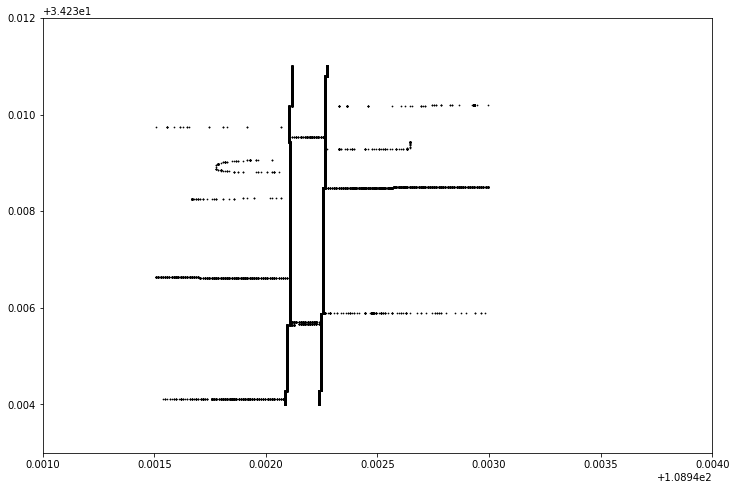

In [15]:
# crop the trips dataset and visualize the trips.
crop_trips_df_et = crop_region(trips_df_et, p1, p2, p3, p4)
plot_gps(crop_trips_df_et)

---
## Add Local Times

The timestamps given in the raw DiDi dataset are in epoch time (a.k.a., Unix time, see https://en.wikipedia.org/wiki/Unix_time for details). However, we are interested in the traffic conditions in terms of local times. The city of Xi’an uses the Beijing Time, which is in UTC+8 time zone.

We therefore convert the Unix time in the cropped data frame to local time (UTC+8)

In [16]:
crop_trips_df_et.head()

,driver_id,order_id,time,lon,lat,lat_wgs,lon_wgs
25,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330804,108.94676,34.23590,34.237497,108.942107
26,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330846,108.94676,34.23491,34.236507,108.942107
27,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330783,108.94676,34.23736,34.238957,108.942107
28,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330843,108.94676,34.23515,34.236747,108.942107
29,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330786,108.94676,34.23711,34.238707,108.942107


In [17]:
import datetime

def add_local_time(crop_trips_df_et):
    """
    Input:
        crop_trips_df_et: the output from the function crop_region(), which should be a Pandas dataframe.
        
    Output:
        The output should also be a dataframe, but with ONE additional columns -- local time -- which converts 
        the epoch time (column "time") to Beijing Time (UTC+8)
    """
    crop_trips_df = crop_trips_df_et.copy()   
    
    crop_trips_df['local_time'] = (pd.to_datetime(crop_trips_df['time'],unit='s')) + datetime.timedelta(hours = 8)
    
    return crop_trips_df

In [18]:
final_crop_df = add_local_time(crop_trips_df_et)
final_crop_df.head()

,driver_id,order_id,time,lon,lat,lat_wgs,lon_wgs,local_time
25,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330804,108.94676,34.23590,34.237497,108.942107,2016-10-13 11:53:24
26,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330846,108.94676,34.23491,34.236507,108.942107,2016-10-13 11:54:06
27,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330783,108.94676,34.23736,34.238957,108.942107,2016-10-13 11:53:03
28,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330843,108.94676,34.23515,34.236747,108.942107,2016-10-13 11:54:03
29,af7ff9e09ccb91b0638c969f1b90fc05,bea5e9bce4f2f79e9098c794f42e07bc,1476330786,108.94676,34.23711,34.238707,108.942107,2016-10-13 11:53:06


---
# SECOND PART: Calculate the average speed

The main task in this second part is to calculate respectively the northbound and southbound average speeds at every 5-minute interval for the interested arterial road (blue and magenta arrows in the figure above). Other branch roads within the region, such as eastbound and westbound roads, are not considered.

<img src = 'Figure3.jpg'>

---
## Define global variables
Those variables are very useful to our implementation

In [19]:
# global variables defined for the start time of the time intervals
global time_tuple
global time_tuple_plt
global g

time_tuple = range(1476288000, 1476288000 + 24*3600, 5*60)
time_tuple_plt = pd.to_datetime(list(time_tuple), unit='s') + pd.Timedelta(8, unit = 'h')
g = pyproj.Geod(ellps='WGS84')
print(len(time_tuple_plt))
time_tuple_plt

288


DatetimeIndex(['2016-10-13 00:00:00', '2016-10-13 00:05:00',
               '2016-10-13 00:10:00', '2016-10-13 00:15:00',
               '2016-10-13 00:20:00', '2016-10-13 00:25:00',
               '2016-10-13 00:30:00', '2016-10-13 00:35:00',
               '2016-10-13 00:40:00', '2016-10-13 00:45:00',
               ...
               '2016-10-13 23:10:00', '2016-10-13 23:15:00',
               '2016-10-13 23:20:00', '2016-10-13 23:25:00',
               '2016-10-13 23:30:00', '2016-10-13 23:35:00',
               '2016-10-13 23:40:00', '2016-10-13 23:45:00',
               '2016-10-13 23:50:00', '2016-10-13 23:55:00'],
              dtype='datetime64[ns]', length=288, freq='5T')

---
## Define useful functions to solve the problem

##### calculate_distance
First we define a functiont that calculate the distance between two points

In [20]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Input:
        lat1, lon1, lat2, lon2 are 4 integers that correspond to the latitudes and longitudes of 2 specific points
        
    Output:
        the output is a distance between these two points
    """
    earth_radius = 6371*1000
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = earth_radius * c
    return d

##### sort_df
The following sort_df function returns a dataset with ordered order_id and local_time

In [21]:
def sort_df(sample_df):
    """
    Input:
        A dataFrame sample_df        
    Output:
        the same dataframe with ordered order_id and local time
    """
    sample_df_out = sample_df.sort_values(['order_id', 'local_time'])
    return sample_df_out

###### dist_azimuths_and_time

This function adds 3 new columns to a dataframe:
- Distance between a point and the following one
- Time difference between the moment a point was taken and the following one
- Forward azimuth between two consecutive points

In [37]:
def dist_azimuths_and_time(sample_df_sorted):
    """
    Input:
        A dataFrame sample_df        
    Output:
        the same dataframe with 3 new columns
    """
    sample_df_out = sample_df_sorted.copy()
    
    List_unique_order = sample_df_out.order_id.unique()
    Dist = []
    Forward_AZ = []
    Time = []
    
    for order in List_unique_order:
        
        df = sample_df_out.loc[sample_df_out['order_id'] == order , :]
        Dist.append(0)
        Forward_AZ.append(0)
        Time.append(0.000001)
        
        for i in range(1, len(df)):
            
            dist = calculate_distance(df.iloc[i-1, 5], df.iloc[i-1, 6], df.iloc[i, 5], df.iloc[i, 6])
            dist = dist/1000
            Dist.append(dist)
            
            az = g.inv(df.iloc[i-1, 6], df.iloc[i-1, 5], df.iloc[i, 6], df.iloc[i, 5])[0]
            Forward_AZ.append(az)
            
            t = (df.iloc[i,7] - df.iloc[i-1,7]).seconds
            t = t/3600
            Time.append(t)
            
    sample_df_out['Distance'] = Dist
    sample_df_out['Time'] = Time
    sample_df_out['Azimuth'] = Forward_AZ
    
    return sample_df_out

##### time_interval

This function adds to every points of a dataframe the time's group that it belongs to.

In [106]:
def time_interval(sample_df):
    """
    Input:
        A dataFrame sample_df        
    Output:
        the same dataframe with a new column: group
    """
    sample_df_out = sample_df.copy()
    
    #Compute the number of the interval where the local_time_min belongs to.
    #For each group, there are 5*60 = 300 seconds.
    #1476288000 corresponds to the TimeStamp '2016-10-13 00:00:00'
    
    sample_df_out['group'] = (sample_df_out['time'] - 1476288000) // 300
    
    return sample_df_out

##### north_south

This function filters northbound/westbound trajectories based on the azimuth

In [97]:
def north_south(sample_df):
    """
    Input:
        A dataFrame sample_df        
    Output:
        two new dataframes
    """
    #Create two new DataFrame: one for the northbound trajectories and the other one for the 
    #southbound trajectories. The absolute value of the forward azimuth for the southbound trajectories 
    #has to be in the interval [170,180]. The absolute value of the forward azimuth for the northbound trajectories
    #has to be in the interval [0,10].
    
    southbounds = sample_df.loc[ abs(sample_df['Azimuth'])>=170  ,:]
    northbounds = sample_df.loc[ abs(sample_df['Azimuth'])<=10  ,:]
    
    return northbounds, southbounds

##### group_by_time_int

This function group speeds into trajectory segments and time intervals. Moreover, it replace the integer indices by the corresponding TimeStamp

In [107]:
dic = {x:y for x,y in zip(list(range(288)), time_tuple_plt)}

In [114]:
def group_by_time_int(sample_df):
    """
    Input:
        A dataFrame sample_df        
    Output:
        the same dataframe with only the distance, the time, and the group as an index
    """
    sample_df_out = sample_df.copy()
    
    #Groupby the interval groups
    sample_df_out = sample_df_out.loc[:,['group','Distance', 'Time']].groupby('group').sum()
    sample_df_out = sample_df_out.reset_index()
    sample_df_out['group'] = sample_df_out['group'].replace(dic)
    sample_df_out = sample_df_out.set_index('group')
    
    return(sample_df_out)

##### speed

This function calculates the speeds (in km/h) for all GPS points

In [127]:
def speed(sample_df):
    """
    Input:
        A dataFrame sample_df        
    Output:
        the same dataframe with speed
    """
    sample_df_out = sample_df.copy()
    sample_df_out['Speed'] = sample_df_out['Distance'] / sample_df_out['Time']
    
    return sample_df_out

##### plot_avg_speed_profile

This function plots the speed profile along the day

In [125]:
def plot_avg_speed_profile(sample_df, direction):
    """
    Input:
        A dataFrame sample_df, and the direction of the trajectories (Northbound/Southbound)        
    Output:
        the same dataframe with speed
    """
    plt.figure(figsize = (15,8))
    plt.plot(list(range(sample_df.shape[0])), sample_df['Speed'])
    plt.xlabel('Time')
    plt.ylabel('Average Speed [km/hr]')
    plt.title(direction)
    plt.show();

---
## Implement the global function function

In [128]:
def speed_profile(sample_df):
    
    sample_df_out = sample_df.copy()
    sample_df_out = sort_df(sample_df_out)
    sample_df_out = dist_azimuths_and_time(sample_df_out)
    sample_df_out = time_interval(sample_df_out)
    north, south = north_south(sample_df_out)
    north = group_by_time_int(north)
    south = group_by_time_int(south)
    north = speed(north)
    south = speed(south)
    
    plot_avg_speed_profile(north, 'Northbounds Speed Profile')
    plot_avg_speed_profile(south, 'Southbounds Speed Profile')

---
# Visualization and Interpretation of the results

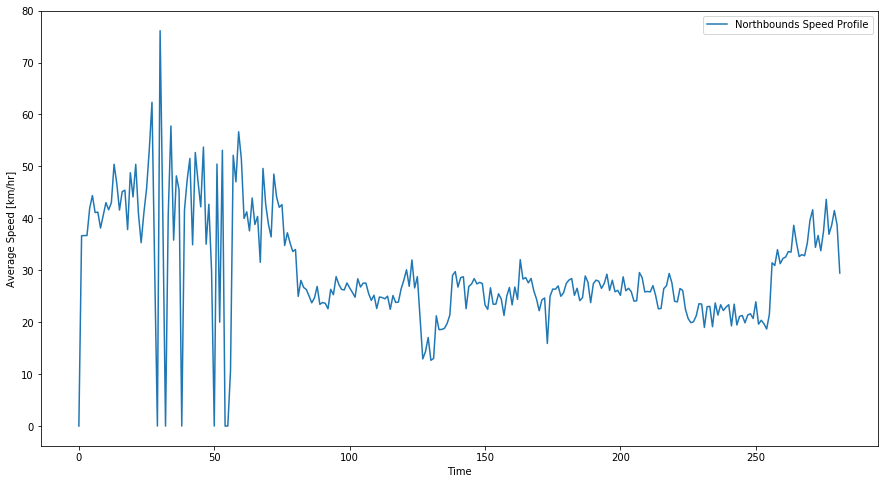

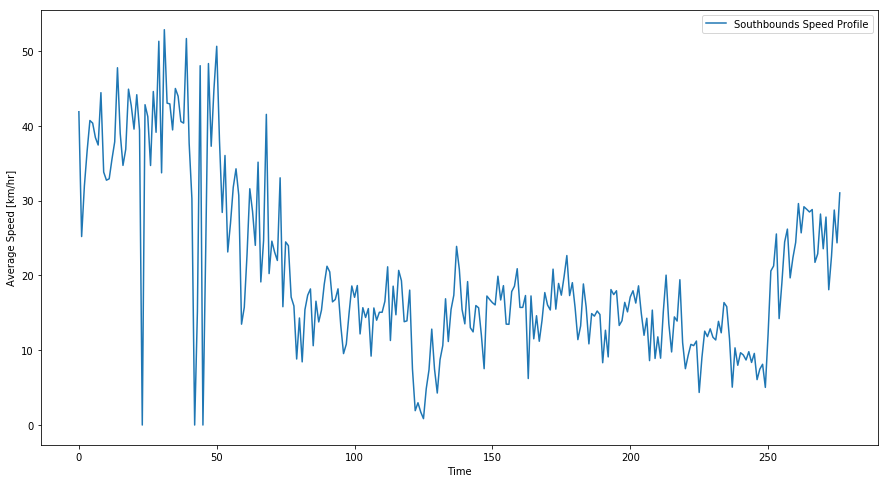

In [129]:
speed_profile(final_crop_df)

As we can see with these two graphs, the speed decreases during the day, and is higher during the night. We can see that some points seem to be wrong (pics near 0). Finally, we can notice that the lowest speed happened during midday approximately.